In [1]:

import pandas as pd  

file_path = "/kaggle/input/ecgtxt/ecg_final.txt"  
  
try:  
    df = pd.read_csv(file_path)  # Carga el archivo CSV directamente desde la ruta  
except FileNotFoundError:  
    print("El archivo no se encontró. Verifica la ruta.")  

# If the loading was successful, continue with analysis  
if 'df' in locals():  
    # Check for null values in the DataFrame  
    print("Valores nulos en el DataFrame:")  
    print(df.isnull().sum())  


    df = df.dropna()  


    print("Primeros 5 registros:", df.head())  

Valores nulos en el DataFrame:
1.0000000e+00  -1.1252183e-01  -2.8272038e+00  -3.7738969e+00  -4.3497511e+00  -4.3760410e+00  -3.4749863e+00  -2.1814082e+00  -1.8182865e+00  -1.2505219e+00  -4.7749208e-01  -3.6380791e-01  -4.9195659e-01  -4.2185509e-01  -3.0920086e-01  -4.9593870e-01  -3.4211867e-01  -3.5533627e-01  -3.6791303e-01  -3.1650279e-01  -4.1237405e-01  -4.7167181e-01  -4.1345783e-01  -3.6461703e-01  -4.4929829e-01  -4.7141866e-01  -4.2477658e-01  -4.6251673e-01  -5.5247236e-01  -4.7537519e-01  -6.9420000e-01  -7.0186810e-01  -5.9381178e-01  -6.6068415e-01  -7.1383066e-01  -7.6980688e-01  -6.7228161e-01  -6.5367605e-01  -6.3940562e-01  -5.5930228e-01  -5.9167032e-01  -4.9322332e-01  -4.6305183e-01  -3.0164382e-01  -2.3273401e-01  -1.2505488e-01  -1.5394314e-01  -2.4357404e-02  -6.5608758e-02   3.4999258e-02   6.1935219e-02   7.1195420e-02   1.2392505e-01   1.0312371e-01   2.2522849e-01   1.2868305e-01   3.0248315e-01   2.5727621e-01   1.9635161e-01   1.7938297e-01   2.4472863

### ----------------------------- aparte -----------------------------------

# DATOS DE electrocardiograma

La función create_sequences tiene como objetivo generar secuencias de datos a partir de un conjunto de datos (en este caso, señales de electrocardiograma) para su uso en modelos de predicción, como las redes neuronales LSTM (Long Short-Term Memory). A continuación se detalla cómo funciona esta función:

In [2]:
# =============================
# 1. Importación de librerías
# =============================
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# =============================
# 2. Cargar datos de electrocardiograma desde archivo
# =============================
try:
    df = pd.read_csv("/kaggle/input/ecgtxt/ecg_final.txt", header=None, delim_whitespace=True)
    df = df.dropna() 
    data = df.iloc[:, 1:].values  # Ignorar la primera columna (etiquetas si hay)
    print("Datos cargados correctamente. Forma:", data.shape)
except FileNotFoundError:
    print("Error: Archivo no encontrado")
    exit()

# =============================
# 3. Función para generar secuencias para predicción
# =============================
def create_sequences(data, n_steps=50, n_out=10):
    X, Y = [], [] #y = tiquetas  ---- x = secuencia en X.
    for i in range(len(data)):
        seq = data[i]
        if len(seq) < n_steps + n_out:
            continue  # Saltar secuencias muy cortas
        for j in range(len(seq) - n_steps - n_out):
            X.append(seq[j:j + n_steps])
            Y.append(seq[j + n_steps:j + n_steps + n_out])
    return np.array(X), np.array(Y)

# =============================
# 4. Crear secuencias
# =============================
n_steps = 50
n_out = 10
X, Y = create_sequences(data, n_steps=n_steps, n_out=n_out)

# Añadir dimensión para LSTM (input_size=1)
X = X[..., np.newaxis]  # shape: (samples, time_steps, 1)
Y = Y[..., np.newaxis]  # shape: (samples, future_steps, 1)

print("Shape de X:", X.shape)
print("Shape de Y:", Y.shape)


/tmp/ipykernel_31/3536316952.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("/kaggle/input/ecgtxt/ecg_final.txt", header=None, delim_whitespace=True)


Datos cargados correctamente. Forma: (5000, 140)
Shape de X: (400000, 50, 1)
Shape de Y: (400000, 10, 1)


In [20]:
# 4. Crear secuencias
# =============================

X, Y = create_sequences(data, n_steps=n_steps, n_out=n_out)

# Añadir dimensión para LSTM (input_size=1)
X = X[..., np.newaxis]  # shape: (samples, time_steps, 1)
Y = Y[..., np.newaxis]  # shape: (samples, future_steps, 1)

print("Shape de X:", X.shape)
print("Shape de Y:", Y.shape)

# =============================
# 5. Separar en train, valid, test
# =============================

#dividir un conjunto de datos en diferentes subconjuntos

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape:", X_test.shape)


Shape de X: (400000, 50, 1)
Shape de Y: (400000, 10, 1)
Train shape: (320000, 50, 1)
Valid shape: (40000, 50, 1)
Test shape: (40000, 50, 1)


y_pred[:, -1]: Selecciona la última columna del arreglo y_pred, que contiene las últimas predicciones para cada serie temporal.

In [50]:
from sklearn.metrics import mean_squared_error
import numpy as np

#Cambia la forma del arreglo a un formato bidimensional con una sola columna.
y_pred_last = y_pred[:, -1].reshape(-1, 1)         # Último valor predicho por serie
y_true_last = Y_test[:, -1].reshape(-1, 1)           # Último valor real por serie


def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$", rows=3, cols=5):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(rows):
        for col in range(cols):
            plt.sca(axes[row][col])
            ix = col + row * cols
            if ix >= len(series):
                continue

            input_series = series[ix].squeeze()
            plt.plot(input_series, ".-", label="input")

            if y is not None:
                y_vals = np.array([y[ix]]) if np.isscalar(y[ix]) or np.ndim(y[ix]) == 0 else y[ix].squeeze()
                plt.plot(
                    range(len(input_series), len(input_series) + len(y_vals)),
                    y_vals, "bx", markersize=8, label="target"
                )

            if y_pred is not None:
                y_pred_vals = np.array([y_pred[ix]]) if np.isscalar(y_pred[ix]) or np.ndim(y_pred[ix]) == 0 else y_pred[ix].squeeze()
                plt.plot(
                    range(len(input_series), len(input_series) + len(y_pred_vals)),
                    y_pred_vals, "ro", label="pred"
                )

            if y_pred_std is not None:
                std_upper = y_pred[ix].squeeze() + y_pred_std[ix]
                std_lower = y_pred[ix].squeeze() - y_pred_std[ix]
                plt.fill_between(
                    range(len(input_series), len(input_series) + len(y_pred[ix])),
                    std_lower,
                    std_upper,
                    color="red", alpha=0.3
                )

            plt.grid(True)
            plt.hlines(0, 0, len(input_series) + 10, linewidth=1)
            plt.axis([0, len(input_series) + 10, -1, 1])
            if x_label and row == rows - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.tight_layout()
    plt.show()

In [52]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# =============================
# 1. Dataset para secuencias ECG
# =============================
class ECGDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32) if y is not None else None
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])
        if self.train and self.y is not None:
            y = torch.from_numpy(self.y[idx])
            return x, y
        return x

# =============================
# 2. Crear datasets y dataloaders
# =============================
dataset = {
    'train': ECGDataset(X_train, Y_train),
    'valid': ECGDataset(X_valid, Y_valid),
    'test': ECGDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(dataset['valid'], batch_size=64, shuffle=False),
    'test': DataLoader(dataset['test'], batch_size=64, shuffle=False)
}


## RNN

## *Long Short-Term Memmory* (LSTM)
## *Gated Recurrent Unit* (GRU)


In [58]:
# Modelo DeepLSTM mejorado
class DeepLSTM(torch.nn.Module):
    def __init__(self, n_out=10):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=1, hidden_size=64, num_layers=2,
            dropout=0.3, batch_first=True
        )
        self.fc1 = torch.nn.Linear(64, 32)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(32, n_out)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch, seq_len, hidden]
        last_out = lstm_out[:, -1, :]  # última salida de la secuencia
        out = self.fc1(last_out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)  # [batch, n_out]
        out = out.unsqueeze(-1)  # [batch, n_out, 1]
        return out


In [69]:
# =============================
# 4. Función de entrenamiento
# =============================
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=50, patience=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()#"Error Cuadrático Medio
    best_loss = np.inf
    patience_counter = 0
    bar = tqdm(range(1, epochs + 1))

    for epoch in bar:
        model.train()
        train_loss = []

        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['valid']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())

        val_loss = np.mean(eval_loss)
        bar.set_description(f"Train Loss: {np.mean(train_loss):.5f} | Val Loss: {val_loss:.5f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break


# =============================
# 5. Función de predicción
# =============================
def predict(model, dataloader):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                X = batch[0]
            else:
                X = batch
            X = X.to(device)
            y_hat = model(X)
            preds.append(y_hat.cpu().numpy())

    return np.concatenate(preds, axis=0)


In [96]:
model = DeepLSTM(n_out=10)
fit(model, dataloader, epochs=150)

Train Loss: 0.04846 | Val Loss: 0.03409:  31%|███       | 46/150 [12:18<27:49, 16.05s/it]

Early stopping


In [98]:
model.load_state_dict(torch.load("best_model.pth"))


/tmp/ipykernel_31/2776843223.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [91]:
print(y_true_last.shape)  
print(y_pred_last.shape)  

(40000,)
(40000,)


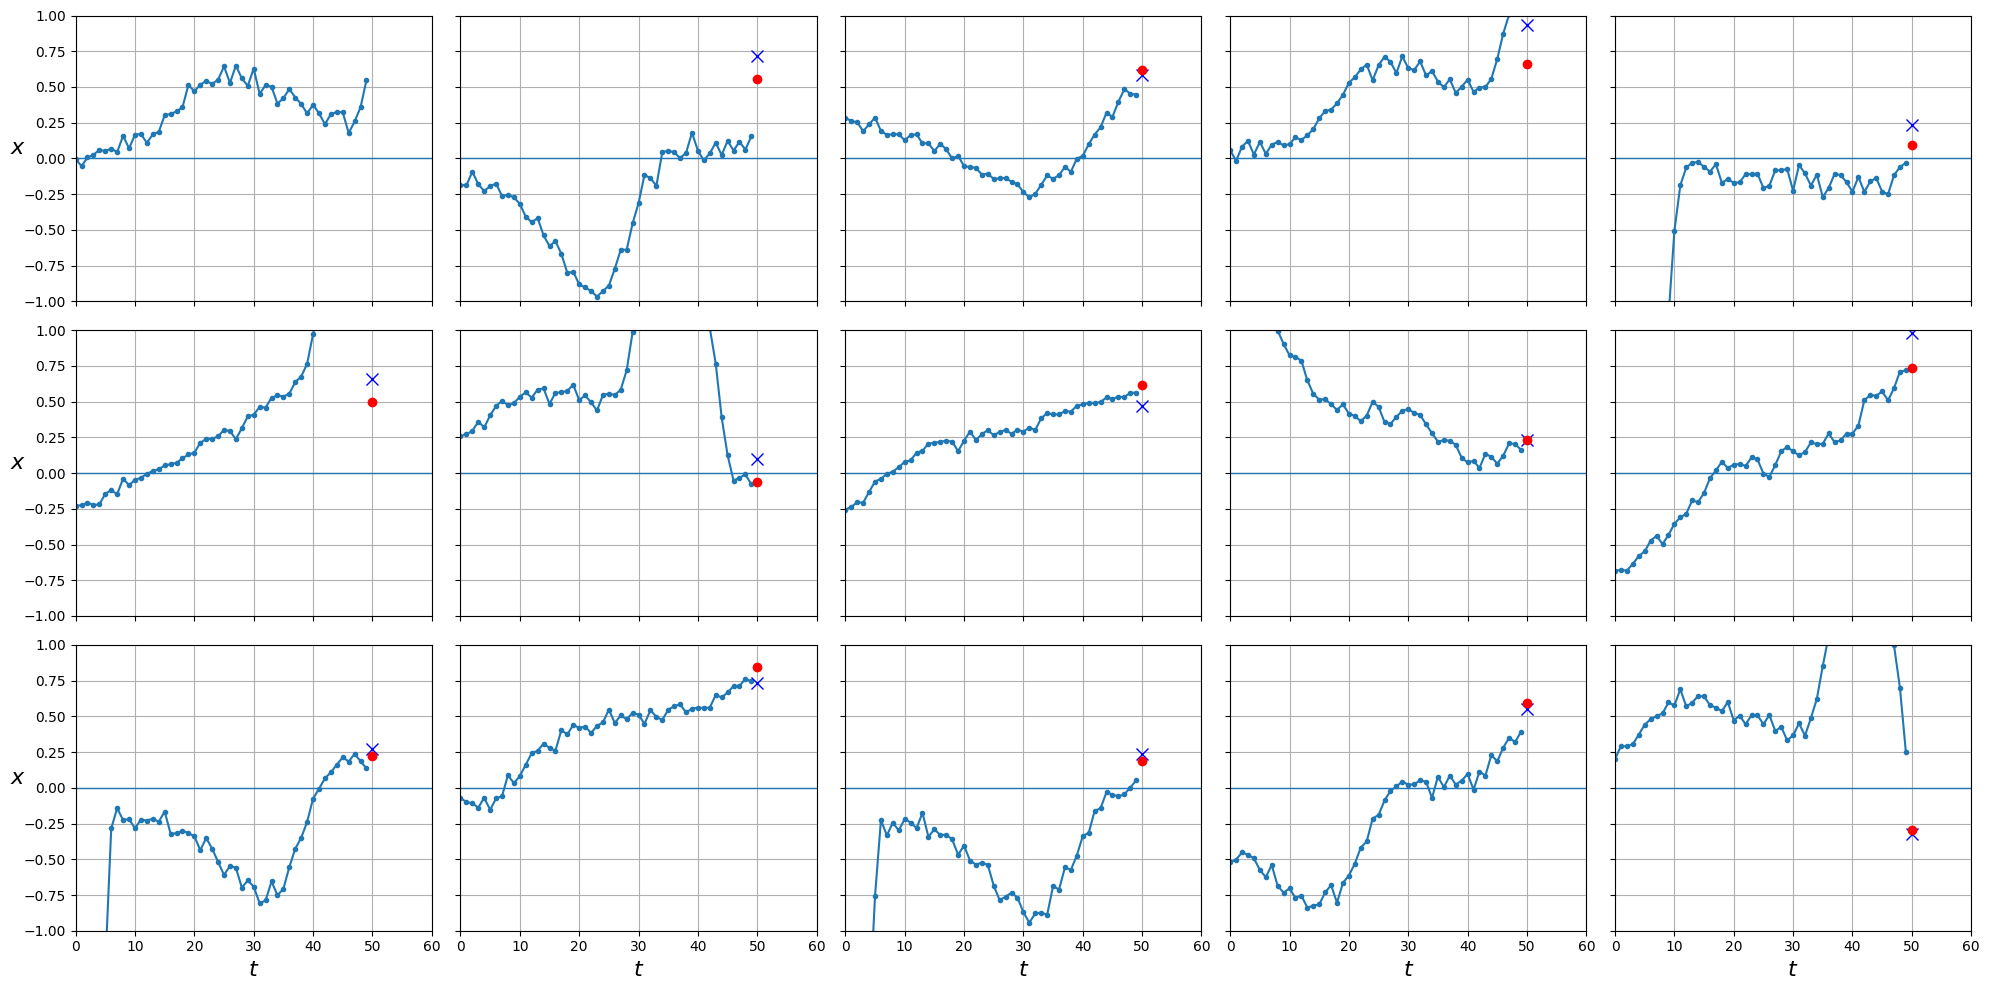

Mean Squared Error: 0.07076


In [99]:
plot_series(X_test, y_true_last, y_pred_last)

# 4. Calcular MSE
mse = mean_squared_error(y_true_last, y_pred_last)
print(f"Mean Squared Error: {mse:.5f}")

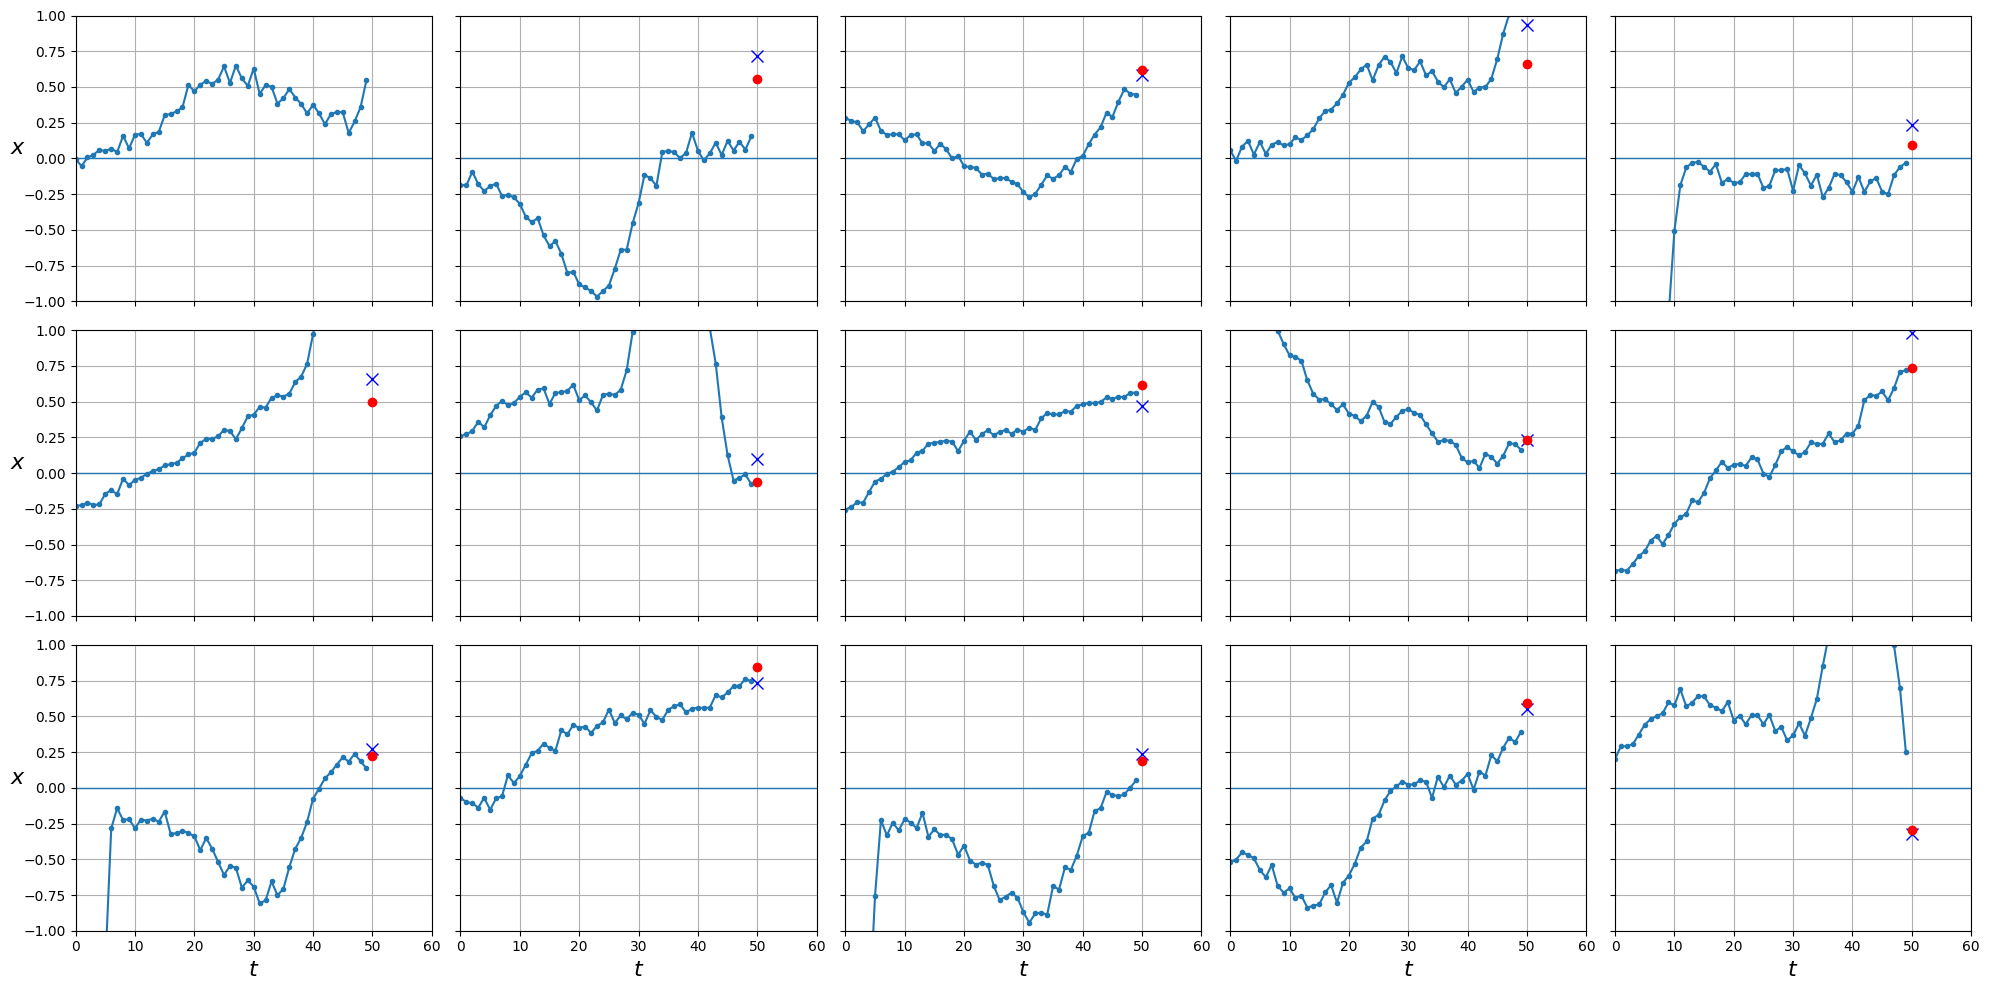

MSE Último paso: 0.07076
MAE Último paso: 0.16439


In [97]:

# Aplanar últimas predicciones
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = predict(model, dataloader['test'])

# Seleccionar la última predicción de cada secuencia
y_pred_last = y_pred[:, -1, 0]  # Esto selecciona la última predicción de la primera salida.  
y_true_last = Y_test[:, -1, 0]        # (n_muestras, )

plot_series(X_test, y_true_last, y_pred_last)
# Evaluación
mse = mean_squared_error(y_true_last, y_pred_last)
mae = mean_absolute_error(y_true_last, y_pred_last)

print(f"MSE Último paso: {mse:.5f}")
print(f"MAE Último paso: {mae:.5f}")
